In [18]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=30):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
pheno['Rating_diff'] = -1*pheno['Rating_diff']
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

In [19]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

(-0.10665493065801339, -6.258499455955152)

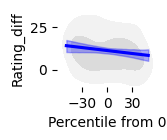

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib.patches import Ellipse
import matplotlib as mpl
plt.style.use('default')

def sub_cmap(cmap, vmin, vmax):
    return lambda v: cmap(vmin + (vmax - vmin) * v)

def corrs(x, y, z):
    #world to voxel
    x, y, z = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    beta = img['PathB(MY)']['beta'].get_fdata()[x, y, z] 
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    correlation = beta*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std()
    fig, ax = plt.subplots(figsize=(1.3, 1))
    data = data4d_harmonized.get_fdata()[x, y, z,:]*100
    for study in pheno.Study_ID.unique():
        data[pheno.Study_ID==study] -= data[pheno.Study_ID==study].mean() # get rid of the mean
        
    if correlation > 0:
        color = 'red'
    else:
        color = 'blue'
    
    cmap = LinearSegmentedColormap.from_list("", ["white","lightgray"])
    sns.kdeplot(y=pheno['Rating_diff'], x=data, levels=3, cmap=cmap, fill=True, thresh=0.33) #levels=[0.5, 0.75], color='gray', fill=['gray', 'red'])
    sns.regplot(y=pheno['Rating_diff'], x=data, color=color, scatter=False, line_kws=dict(alpha=1)) #, x_estimator=np.mean, x_bins=np.arange(-100, 100, 50))
    plt.setp(ax.collections[1], alpha=0.3, color=color, zorder=10)
    plt.xticks([-30, 0, 30])
    #plt.yticks([5, 10, 15])
    plt.ylim(-10, 35)
    plt.xlim(-60, 60)
    plt.xlabel('Percentile from 0')
    sns.despine(left=True, bottom=True)
    return correlation, beta

# test it
corrs(-10, 0, 0)

## MricroGL scripts
We select slices with at least n_sign significant voxels

In [21]:
from nilearn.plotting import find_cut_slices

coords = find_cut_slices(img['PathB(MY)']['uncorr_logp'], direction="z", n_cuts=9)
coords = ' '.join(str(z) for z in coords)
f'A H -0.1 V -0.1 {coords} S X R 0'

'A H -0.1 V -0.1 -44.0 -32.0 -20.0 0.0 18.0 30.0 40.0 58.0 70.0 S X R 0'

In [22]:
nip.view_img(img['PathB(MY)']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [23]:
clust_table = get_clusters_table(stat_img=img['PathB(MY)']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=15, #voxels
                                 min_distance=20 #mm
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = img['PathB(MY)']['beta'].get_fdata()[x_vox, y_vox, z_vox] 
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    clust_table.loc[row.name, 'Correlation'] = clust_table.loc[row.name, 'Effect size']*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std()
    
    clust_table.loc[row.name, 'Direction'] = np.sign(clust_table.loc[row.name, 'Effect size'])
    
    clust_table.loc[row.name, 'Mean INST'] = img['INST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]+0.5
    clust_table.loc[row.name, 'Mean COND'] = img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]+0.5
    
    mars_region = get_mars_label([x, y, z])
    clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['PathB(MY)']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Mean INST', 'Mean COND',
     'Effect size', 'Correlation', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_36955/982285010.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_36955/982285010.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'


,Cluster ID,Cluster Size (mm3),X,Y,Z,Mean INST,Mean COND,Effect size,Correlation,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
0,1,5320,64.0,-40.0,18.0,0.572335,0.498110,-9.284883,-0.158229,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Angular gyrus RH,DorsAttnB
1,1a,,54.0,-22.0,26.0,0.438658,0.395413,-9.992364,-0.170286,<0.0001,<0.0001,Right Ventral Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA
2,1b,,48.0,-36.0,6.0,0.381951,0.293699,-7.696351,-0.131158,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Superior temporal sulcus posterior RH,DefaultB
3,1c,,60.0,-22.0,22.0,0.547153,0.495981,-9.862708,-0.168076,<0.0001,<0.0001,Right Ventral Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA
4,2,600,-26.0,52.0,26.0,0.380932,0.343066,-8.243396,-0.140481,<0.0001,<0.0001,Left Rostral Dorsolateral Superior Prefrontal ...,Lateral frontal pole,ContA
5,3,160,-20.0,-4.0,24.0,0.526370,0.402376,-8.567742,-0.146008,<0.0001,<0.0001,Left Caudate,Lateral ventricles superior,No network found
6,4,288,-22.0,-58.0,-26.0,0.254477,0.219055,-9.007954,-0.153510,<0.0001,<0.0001,Left Caudal Medial Visual Cortex,Cerebellum VI anterior,No network found
7,5,1120,-18.0,-76.0,12.0,0.274075,0.209940,-9.579421,-0.163249,<0.0001,<0.0001,Left Cuneus,Intracalcarine cortex,VisCent
8,6,384,-10.0,-12.0,36.0,0.358818,0.419846,-9.210076,-0.156955,<0.0001,<0.0001,Left Mid Cingulate Cortex,Cingulate sulcus posterior,SalVentAttnA
9,7,2768,-36.0,-46.0,66.0,0.401647,0.423650,-8.089600,-0.137860,<0.0001,<0.0001,Left Superior Parietal Cortex,Postcentral gyrus middle,DorsAttnB


4.0 -20.0 -32.0 beta: -7.69639402405075 r: -0.1311589745639124 q: <0.0001 Right Medial Inferior Temporal Cortex Middle frontal gyrus lateral LH ContA


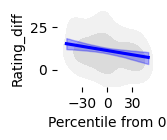

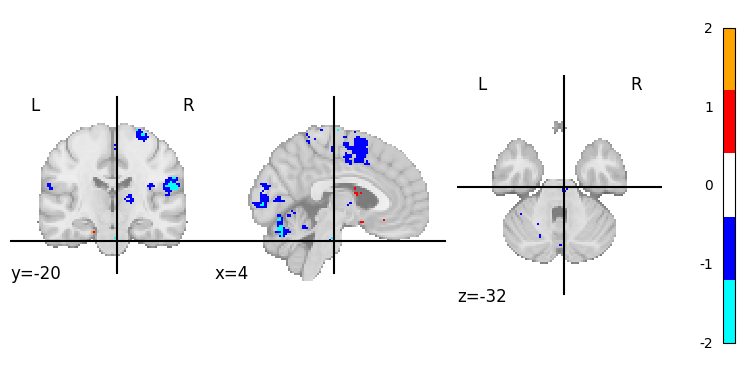

-22.0 -58.0 -26.0 beta: -9.007954228267483 r: -0.15351007703168387 q: <0.0001 Left Caudal Medial Visual Cortex Cerebellum VI anterior No network found


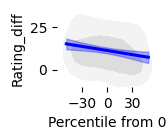

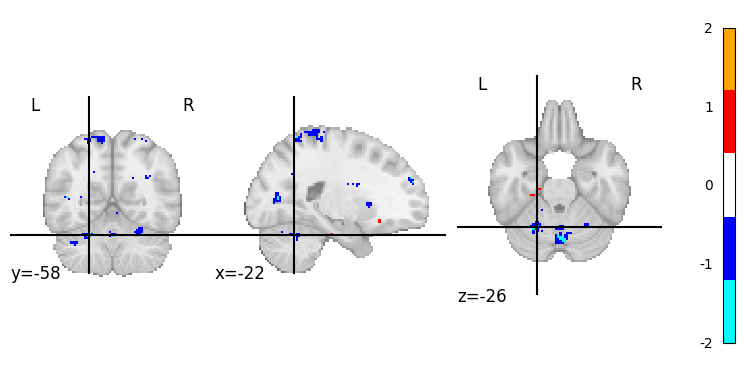

6.0 -70.0 -20.0 beta: -9.032104336231288 r: -0.15392163384468516 q: <0.0001 Right Caudal Medial Visual Cortex Cerebellum IV and V No network found


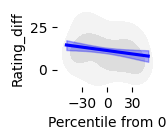

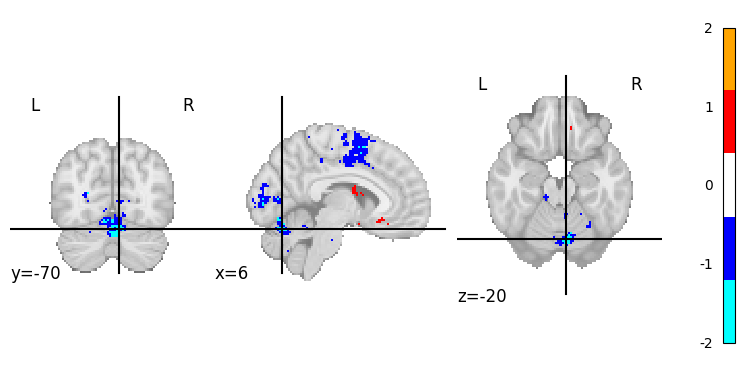

30.0 -2.0 -16.0 beta: -9.322948618473024 r: -0.15887808977682644 q: <0.0001 Right Amygdala Hippocampal fissure No network found


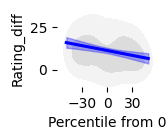

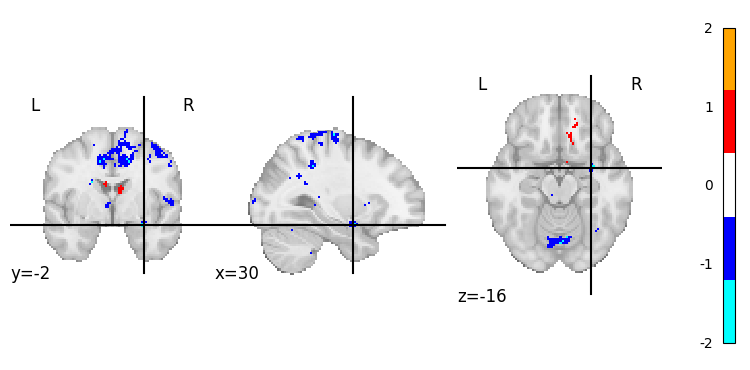

-12.0 -78.0 -12.0 beta: -8.362562922806825 r: -0.14251156765805223 q: 0.0006409090327677125 Left Caudal Medial Visual Cortex Lingual gyrus posterior VisCent


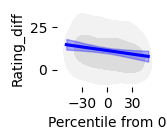

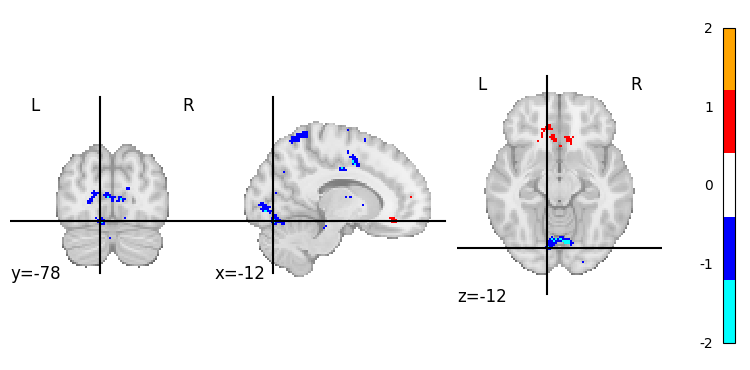

-12.0 -86.0 -4.0 beta: -8.081473945439859 r: -0.13772135786402895 q: 0.02042925684407368 Left Caudal Medial Visual Cortex Lingual gyrus posterior VisCent


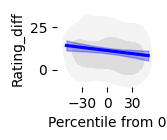

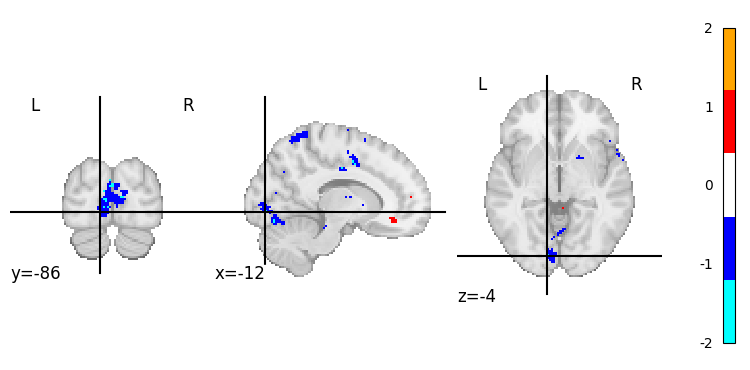

6.0 -88.0 4.0 beta: -8.842507151696394 r: -0.1506905918494218 q: <0.0001 Right Caudal Medial Visual Cortex Calcarine cortex posterior VisCent


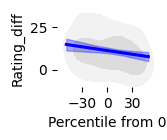

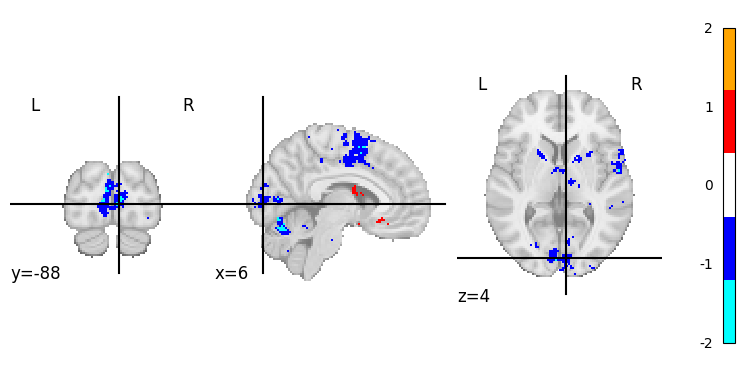

48.0 -36.0 6.0 beta: -7.696350930191727 r: -0.13115824017501002 q: <0.0001 Right Caudal Superior Temporal Cortex Superior temporal sulcus posterior RH DefaultB


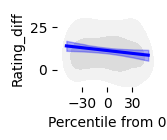

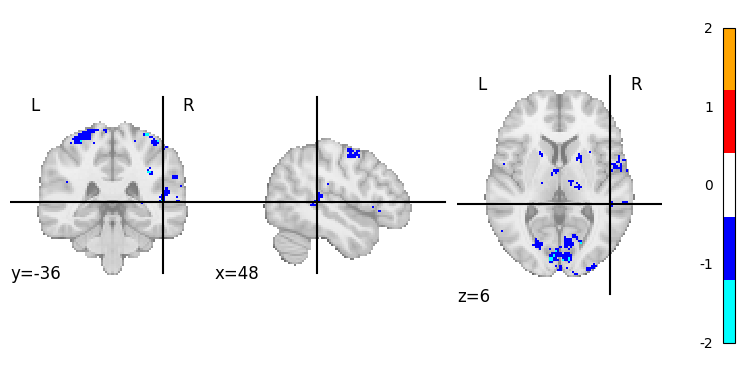

26.0 -98.0 8.0 beta: -8.633311928950953 r: -0.14712556765585535 q: 0.002019094826219673 Right Caudal Medial Visual Cortex Occipital pole superior VisCent


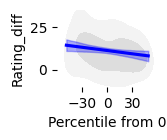

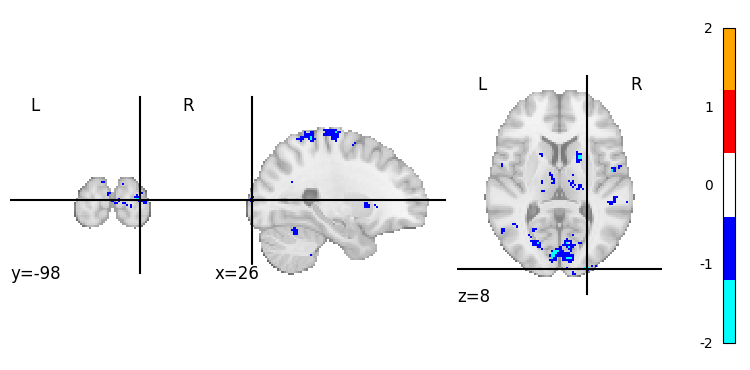

18.0 10.0 8.0 beta: -9.946490250448408 r: -0.16950424545339818 q: <0.0001 Right Puttamen Caudate No network found


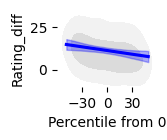

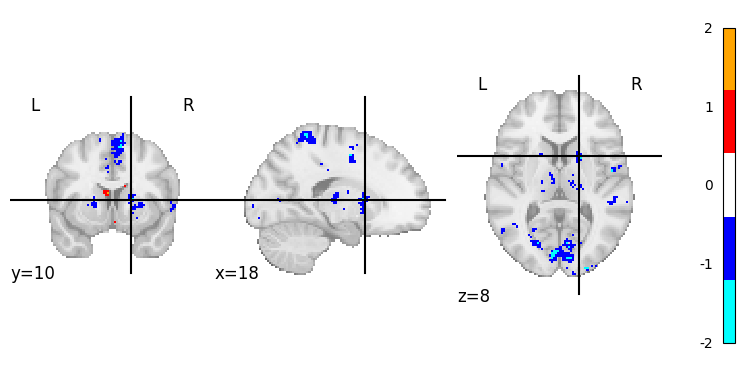

50.0 -4.0 8.0 beta: -8.20238729897088 r: -0.13978191653743555 q: 0.014840577563336942 Right Ventral Motor Cortex Central operculum cortex SomMotA


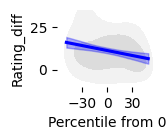

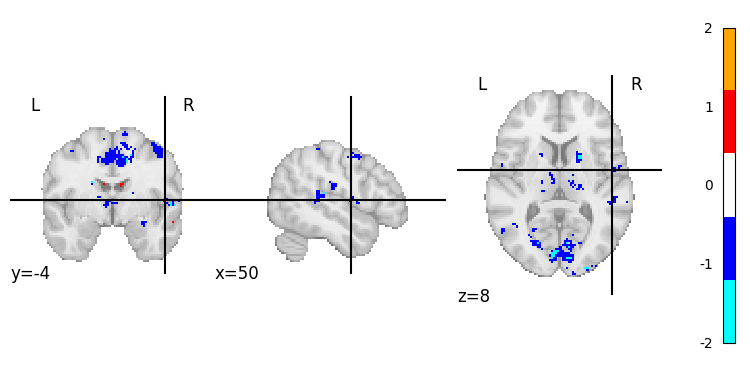

6.0 -74.0 8.0 beta: -8.0959335250503 r: -0.13796777243537292 q: 0.004855918482846473 Right Rostral Medial Visual Cortex Calcarine cortex anterior VisCent


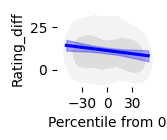

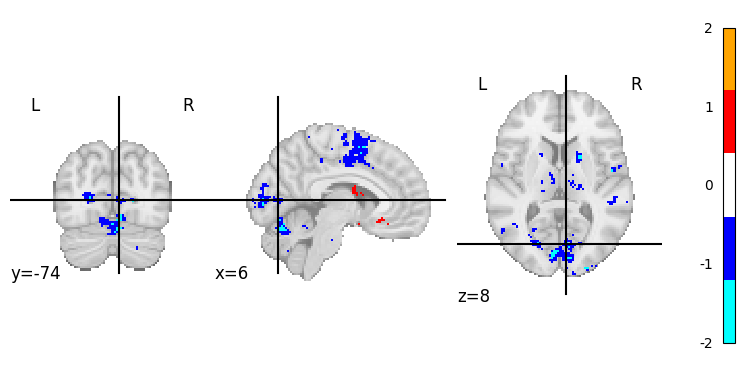

-8.0 -8.0 10.0 beta: -8.286319073612914 r: -0.14121224942592567 q: 0.0062071464844441595 Left Thalamus Thalamus No network found


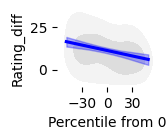

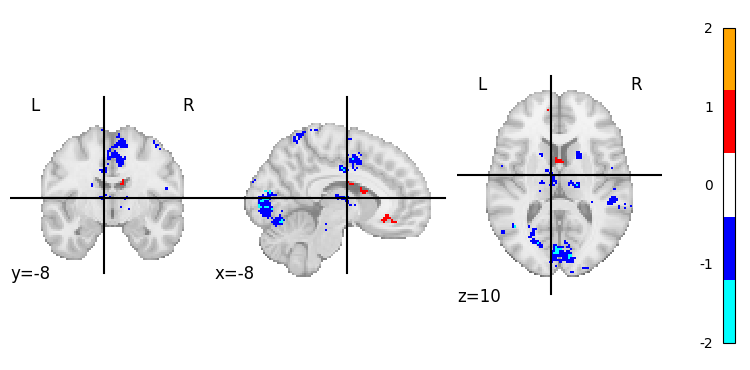

16.0 -18.0 10.0 beta: -8.65104177044707 r: -0.14742771276726008 q: <0.0001 Right Thalamus Thalamus No network found


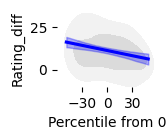

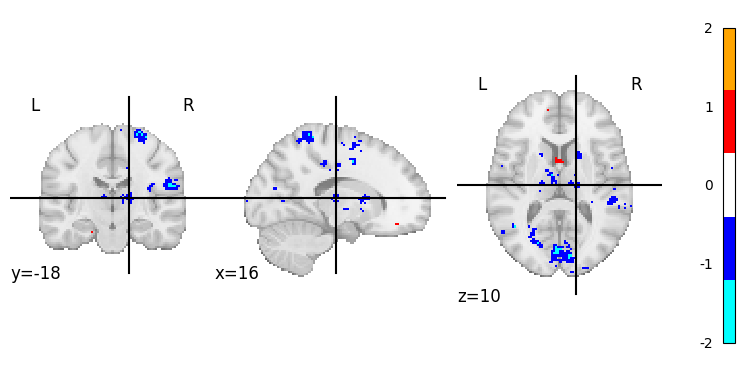

-18.0 -76.0 12.0 beta: -9.579420649672485 r: -0.16324878708147672 q: <0.0001 Left Cuneus Intracalcarine cortex VisCent


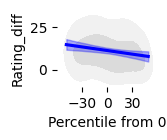

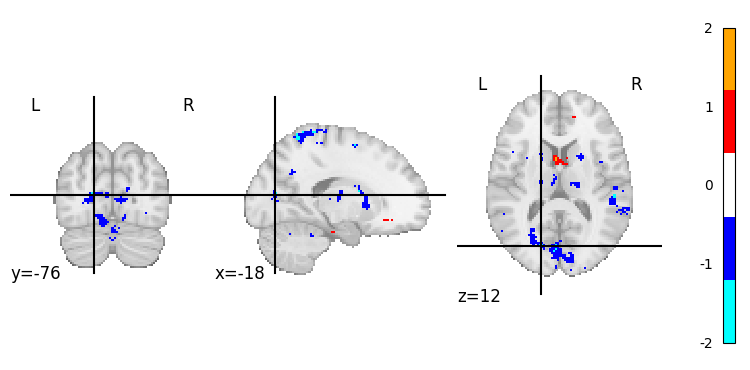

-18.0 4.0 16.0 beta: -8.005672313082187 r: -0.13642957572043876 q: 0.00140384341664563 Left Caudate Caudate No network found


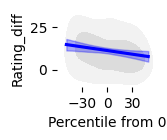

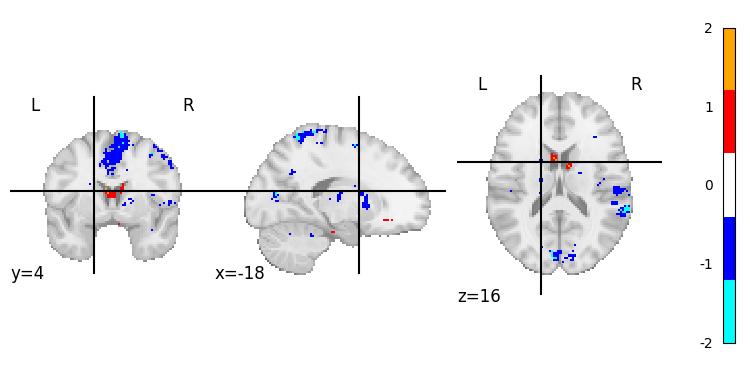

64.0 -40.0 18.0 beta: -9.284882631022032 r: -0.1582293839200014 q: <0.0001 Right Caudal Superior Temporal Cortex Angular gyrus RH DorsAttnB


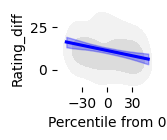

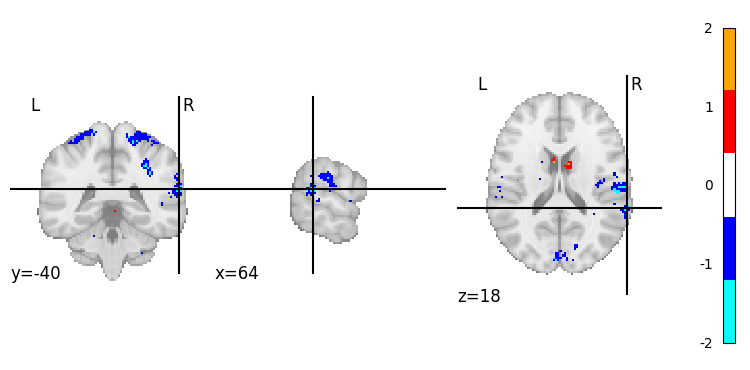

8.0 2.0 18.0 beta: 8.646971117250667 r: 0.14735834226759786 q: <0.0001 Right Caudate Lateral ventricles superior No network found


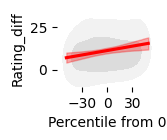

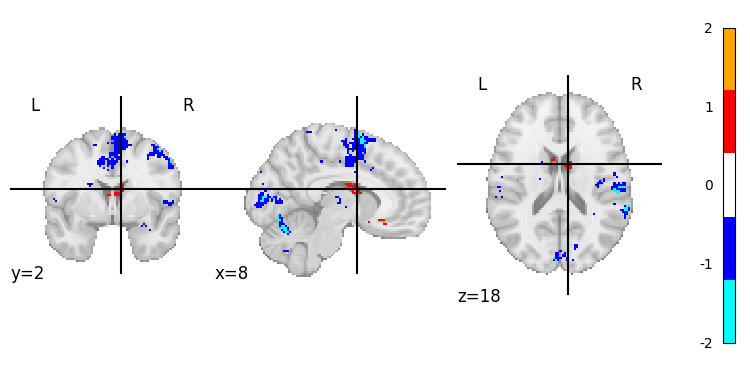

32.0 -48.0 20.0 beta: -7.6229405320105705 r: -0.12990720852074691 q: <0.0001 Right Caudal Middle Temporal Cortex Internal capsule No network found


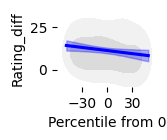

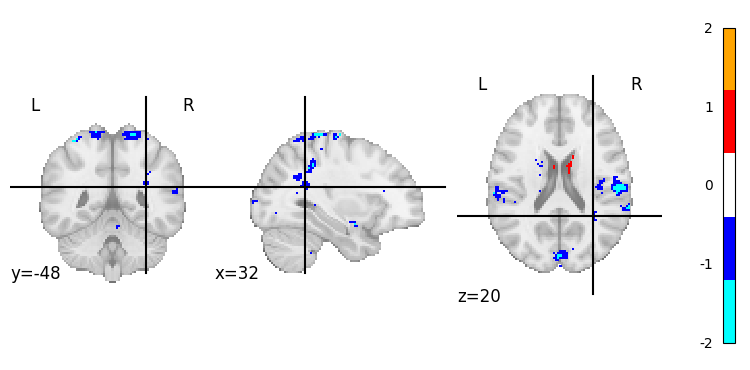

60.0 -22.0 22.0 beta: -9.862708013352735 r: -0.16807646092602085 q: <0.0001 Right Ventral Inferior Parietal Cortex Supramarginal gyrus anterior RH SalVentAttnA


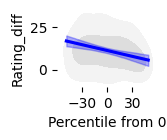

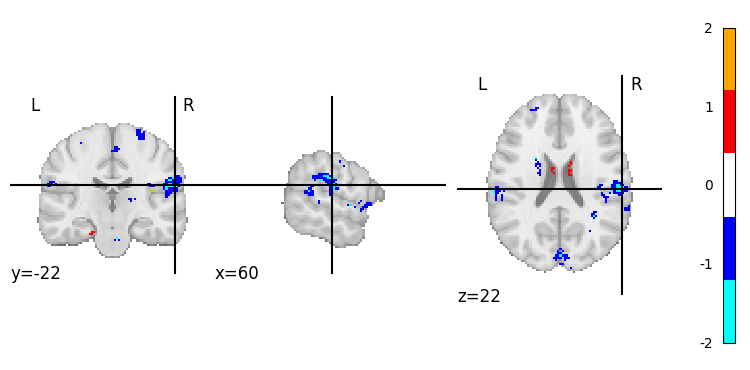

-50.0 -38.0 24.0 beta: -8.348352598188614 r: -0.14226940079402206 q: <0.0001 Left Ventral Inferior Parietal Cortex Supramarginal gyrus LH SalVentAttnA


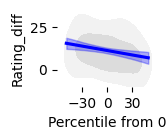

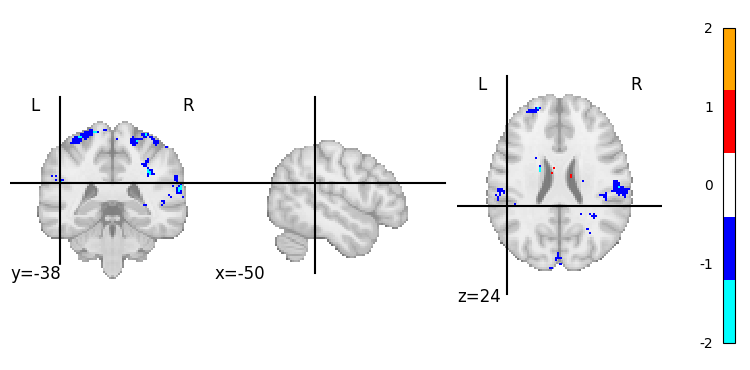

-20.0 -4.0 24.0 beta: -8.56774240167382 r: -0.1460081570953468 q: <0.0001 Left Caudate Lateral ventricles superior No network found


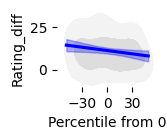

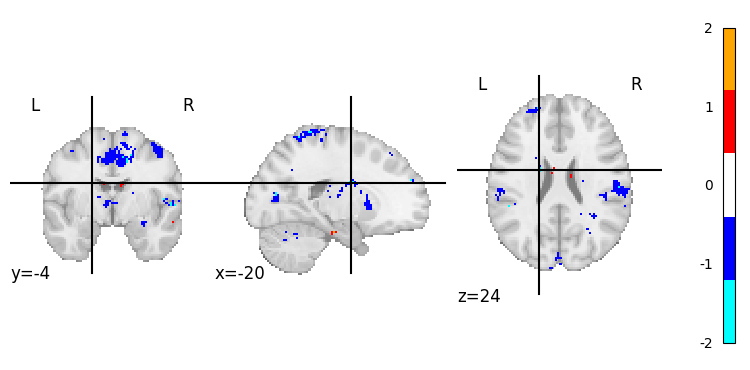

54.0 -22.0 26.0 beta: -9.99236446733857 r: -0.17028601614074007 q: <0.0001 Right Ventral Inferior Parietal Cortex Supramarginal gyrus anterior RH SalVentAttnA


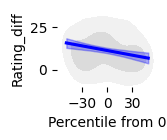

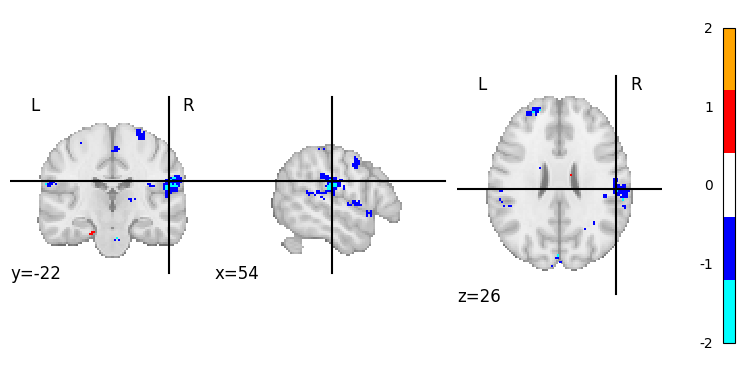

-2.0 -86.0 26.0 beta: -8.061240987362163 r: -0.13737655560655976 q: 0.0007268770900881852 Left Cuneus Cuneus VisCent


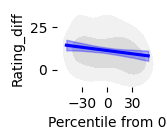

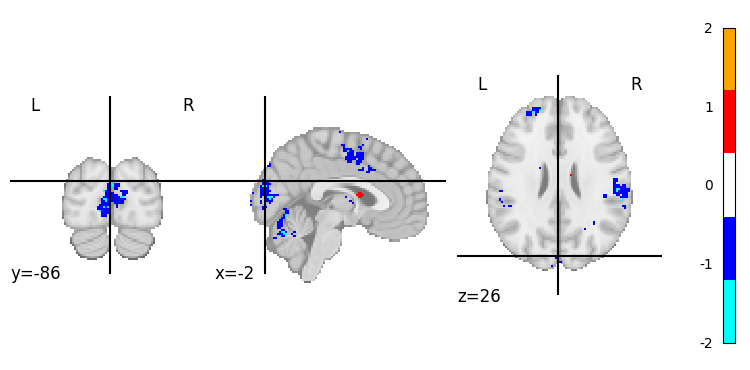

-26.0 52.0 26.0 beta: -8.243396262883017 r: -0.14048077546251608 q: <0.0001 Left Rostral Dorsolateral Superior Prefrontal Cortex Lateral frontal pole ContA


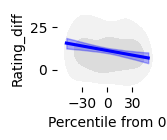

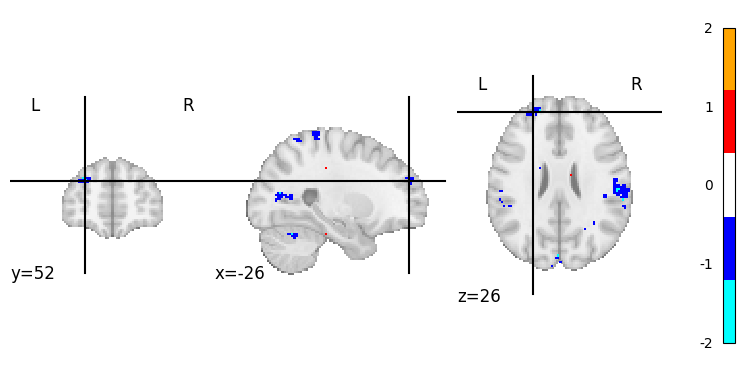

-60.0 -32.0 28.0 beta: -7.63341766221214 r: -0.13008575572731096 q: <0.0001 Left Ventral Inferior Parietal Cortex Supramarginal gyrus LH SalVentAttnA


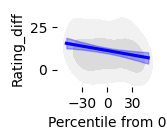

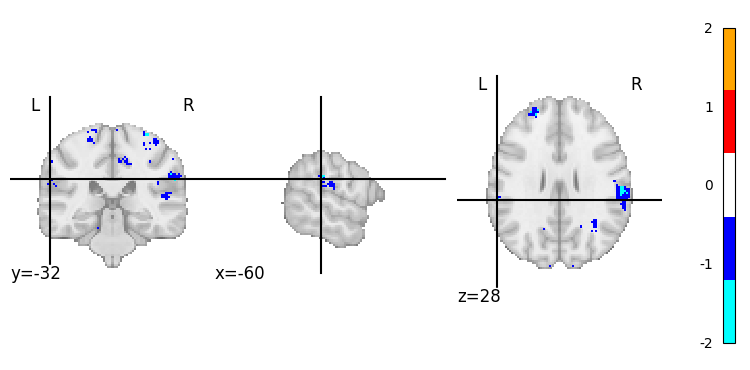

36.0 -40.0 32.0 beta: -8.376418401139436 r: -0.14274768736872695 q: <0.0001 Right Dorsal Inferior Parietal Cortex Middle frontal gyrus lateral LH ContA


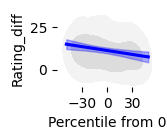

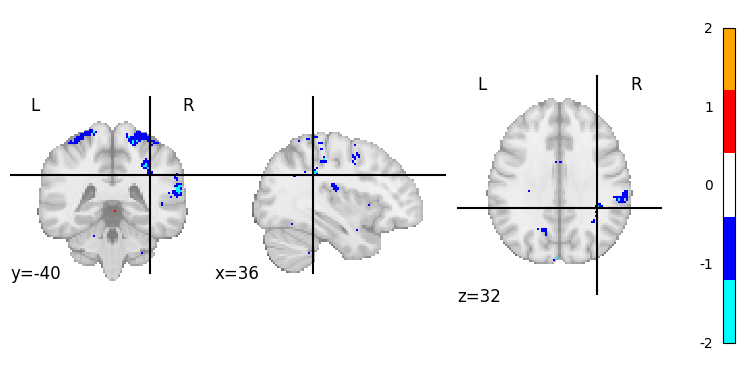

-10.0 -12.0 36.0 beta: -9.210075560337208 r: -0.15695455071233416 q: <0.0001 Left Mid Cingulate Cortex Cingulate sulcus posterior SalVentAttnA


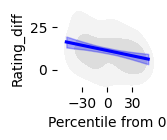

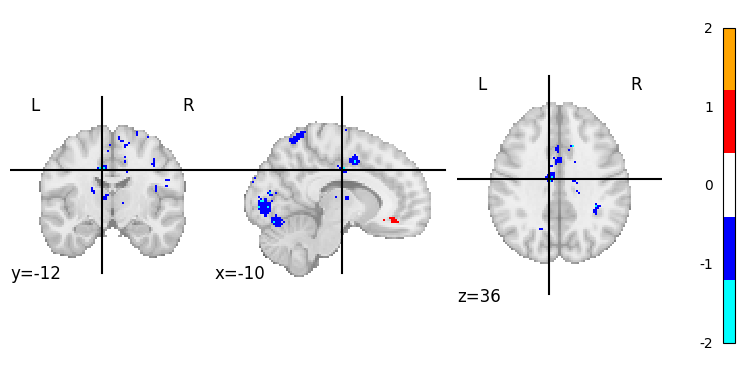

38.0 -26.0 40.0 beta: -7.272134426587025 r: -0.12392890635556028 q: 0.037618502907318226 Right Dorsolateral Somatosensory Cortex Middle frontal gyrus lateral LH ContA


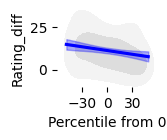

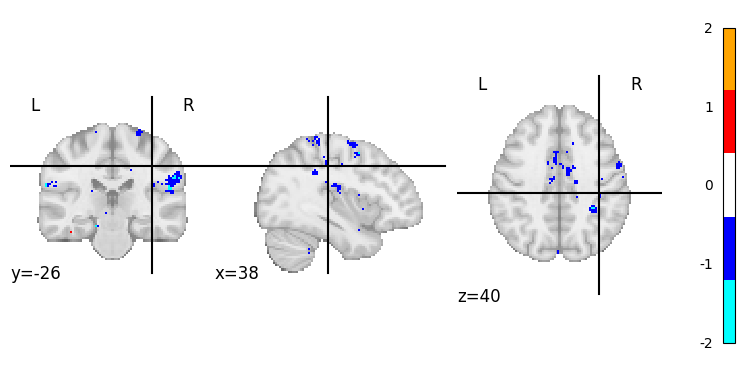

-10.0 0.0 44.0 beta: -9.463640287047463 r: -0.16127570285669798 q: <0.0001 Left Dorsomedial Premotor Cortex Paracingulate gyrus postero-inferior SomMotA


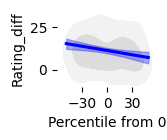

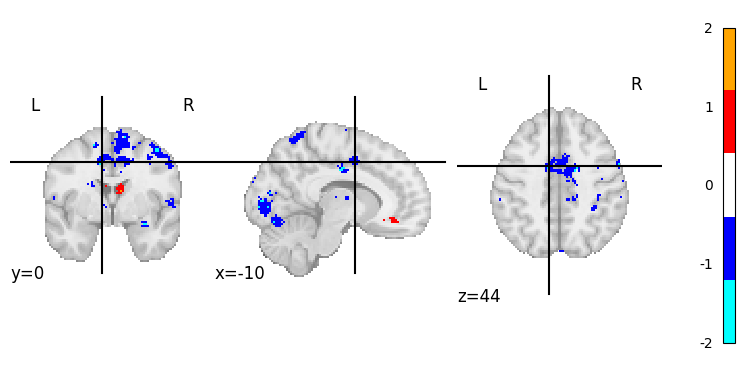

56.0 2.0 44.0 beta: -11.02410822219236 r: -0.18786859474527481 q: 0.0017491997003160453 Right Dorsolateral Motor Cortex Precentral gyrus superior SomMotA


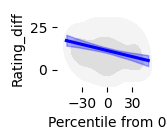

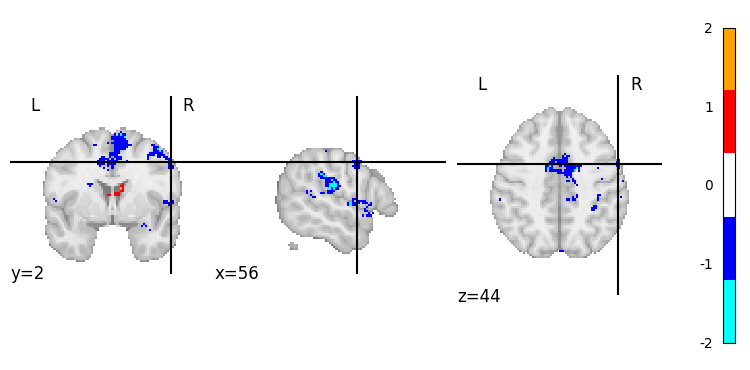

18.0 -4.0 50.0 beta: -8.020772250174689 r: -0.13668690301668207 q: <0.0001 Right Dorsomedial Motor Cortex Middle frontal gyrus lateral LH ContA


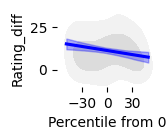

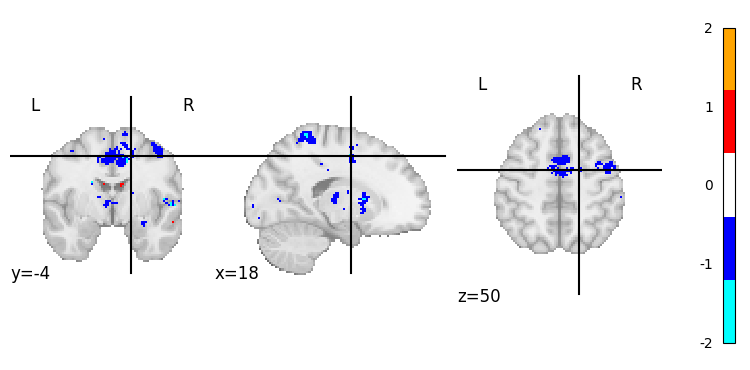

42.0 0.0 56.0 beta: -9.395009323356925 r: -0.16010612047917744 q: <0.0001 Right Dorsolateral Premotor Cortex Precentral sulcus superior DorsAttnB


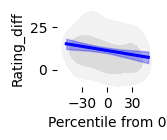

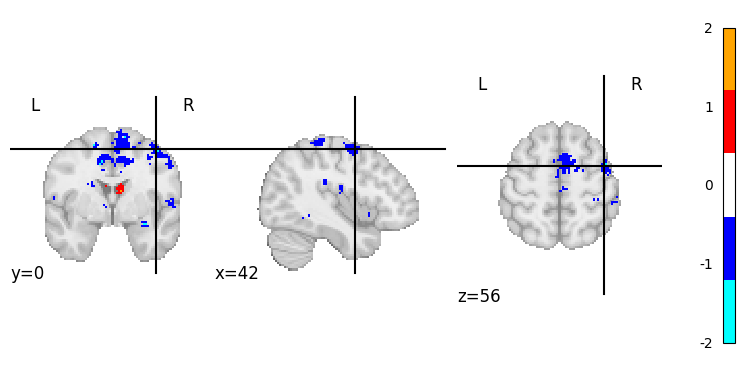

10.0 4.0 62.0 beta: -10.815713735402186 r: -0.18431721638460893 q: 0.0006368912328088329 Right Dorsomedial Premotor Cortex Paracingulate gyrus postero-superior SalVentAttnA


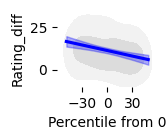

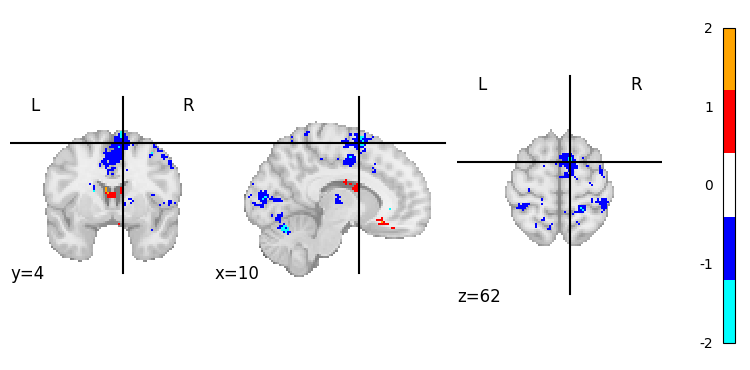

44.0 -36.0 64.0 beta: -9.421082054395152 r: -0.16055044189208437 q: <0.0001 Right Dorsolateral Somatosensory Cortex Postcentral gyrus middle DorsAttnB


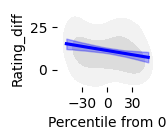

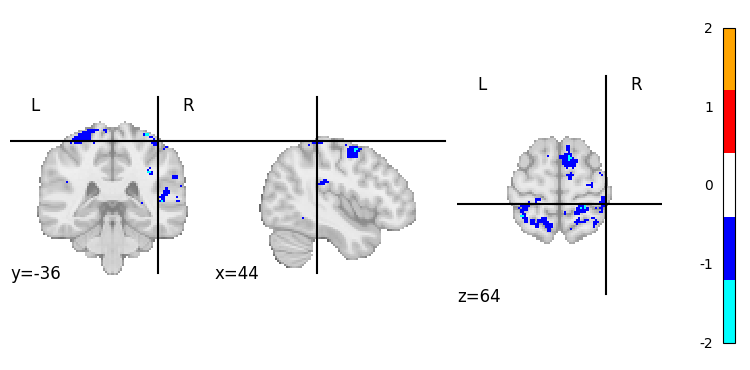

-38.0 -48.0 64.0 beta: -8.369959254918387 r: -0.1426376130933892 q: <0.0001 Left Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


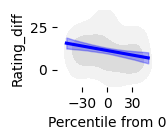

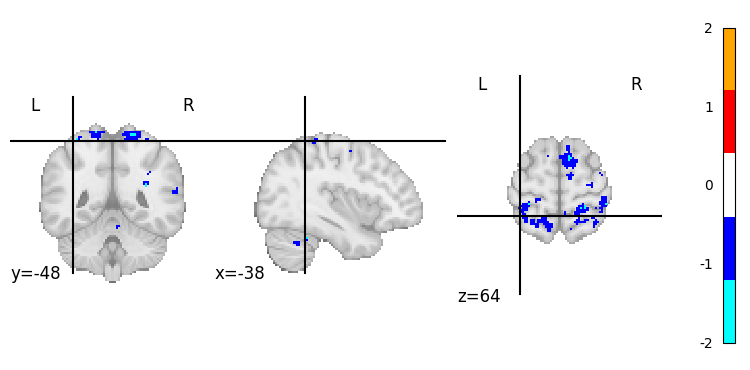

-36.0 -46.0 66.0 beta: -8.089600456838992 r: -0.1378598467327851 q: <0.0001 Left Superior Parietal Cortex Postcentral gyrus middle DorsAttnB


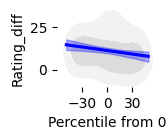

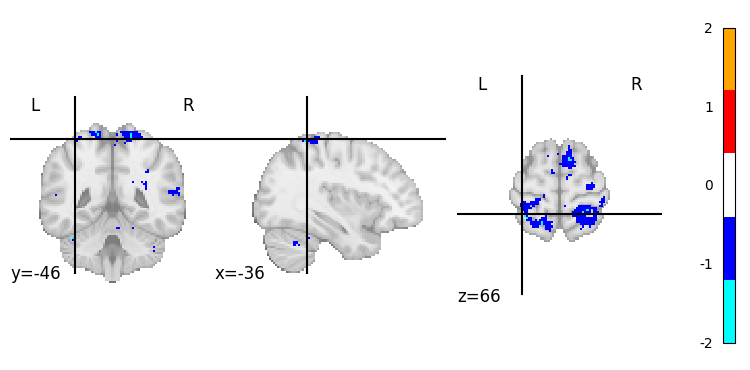

20.0 -52.0 68.0 beta: -10.016445837651377 r: -0.17069640155323995 q: <0.0001 Right Medial Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


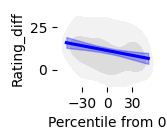

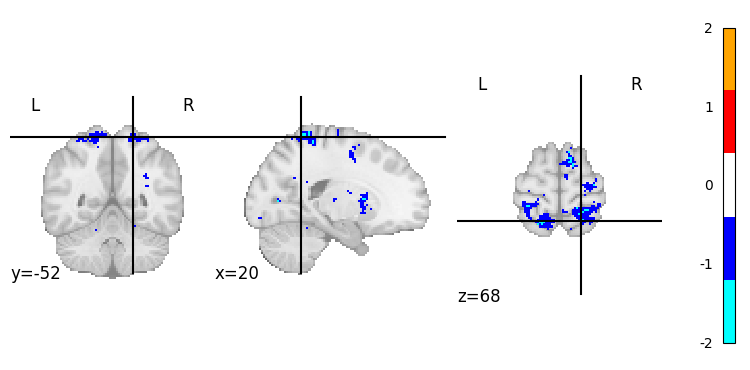

32.0 -36.0 70.0 beta: -10.614985122807644 r: -0.180896476891378 q: <0.0001 Right Dorsolateral Somatosensory Cortex Superior precentral and postcentral sulci anterior SomMotA


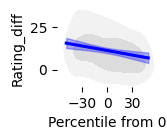

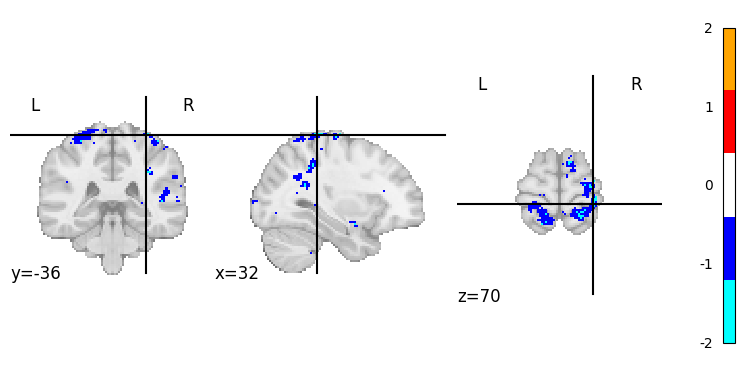

8.0 4.0 70.0 beta: -9.000935337200119 r: -0.15339046380085203 q: <0.0001 Right Dorsomedial Premotor Cortex Cerebrospinal fluid (between superior part of superior frontal gyrus and skull) SalVentAttnA


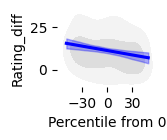

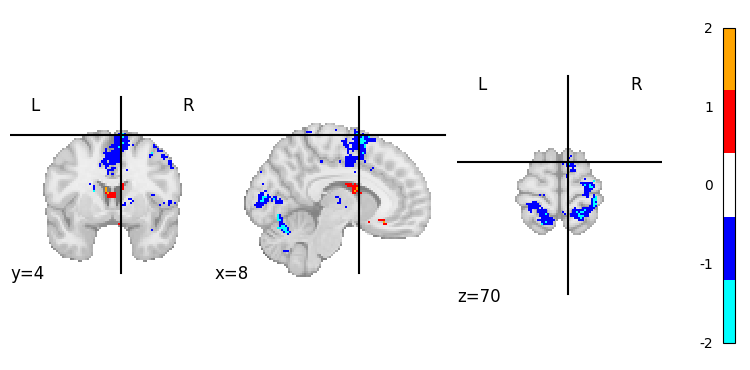

30.0 -20.0 70.0 beta: -8.492840011897881 r: -0.14473169949654158 q: <0.0001 Right Dorsomedial Motor Cortex Superior precentral and postcentral sulci anterior SomMotA


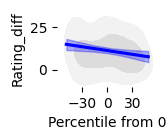

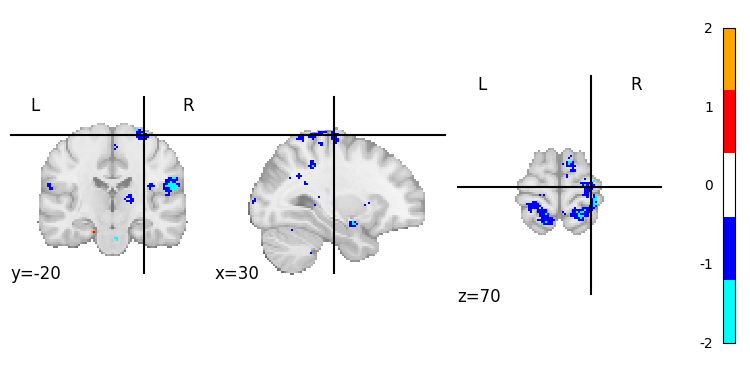

-16.0 -46.0 72.0 beta: -11.061264674167845 r: -0.18850180064979435 q: <0.0001 Left Dorsomedial Somatosensory Cortex Superior precentral and postcentral sulci posterior SomMotA


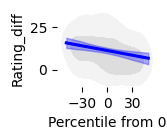

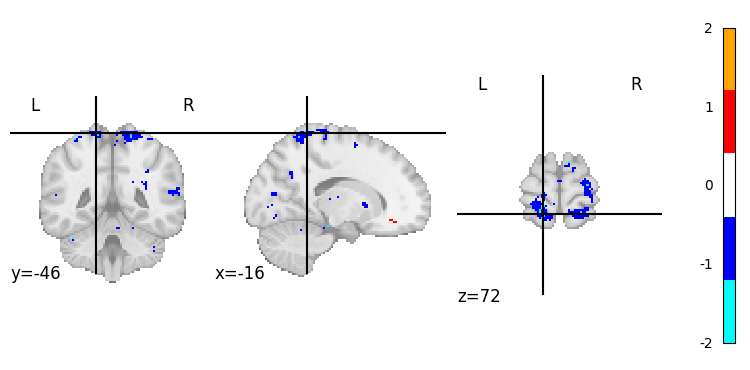

-20.0 -42.0 72.0 beta: -11.342523414507376 r: -0.19329490347883257 q: 0.004232017572590503 Left Dorsomedial Somatosensory Cortex Superior precentral and postcentral sulci posterior SomMotA


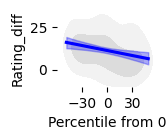

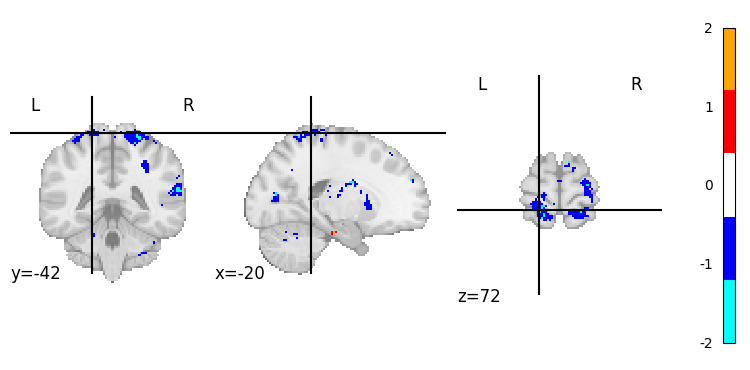

In [35]:
def table2bar(clust_id):
    row = clust_table.loc[clust_table['Cluster ID'] == clust_id, :]
    corrs(row['X'].values[0], row['Y'].values[0], row['Z'].values[0])
    # adjust here:
    nip.plot_stat_map(img['PathB(MY)']['thres'], cut_coords=(row['X'].values[0], row['Y'].values[0], row['Z'].values[0]), draw_cross=True, cmap=my_cmp)
    return row

for i in clust_table.sort_values(by='Z')['Cluster ID']:
    row = table2bar(i)
    print(row['X'].values[0], row['Y'].values[0], row['Z'].values[0], 'beta:', row['Effect size'].values[0], 'r:', row['Correlation'].values[0], 'q:', row['Peak Stat FDR'].values[0], row['Mars region'].values[0], row['DiFuMo region'].values[0], row['yeo_network'].values[0])
    plt.show()


In [31]:
(9*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std())

0.15337452414552052

(0.1578651739103202, 9.263510828205414)

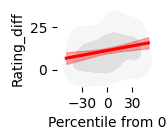

In [36]:
corrs(10, 26, -14)

In [37]:
10**(-304.39)

4.0738027780412554e-305